# Convolutional Neural Networks

In this section we will build a CNN classify images of cats and dogs. 

The CNN will have 3 convolutional layers. Each convolutional layer will be follwed by a relu layer and a pooling layer. 

The first two CNN layers will have 32 filters and the last will 64. Each filter has a size of 3X3. 

We will add 1 fully connected layer with 64 nodes and a dropout layer with 50% dropout. 

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150
input_shape = (3, img_width, img_height)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Data Preparation

In this section we will prepare data for training the model defined in the previous section. 

### Data augmentation

There are a number of ways to augmentate data, for example rotating or flipping the images. The code below demonstrates how to augment data with Keras.

In [68]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat020.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 4:
        break  # otherwise the generator would loop indefinitely



In the following code block we will define the augmentation we wish to use for training our CNN




In [69]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)



Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


## Training and Model Evaluation

In [20]:

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

Epoch 1/20
125/125 [==============================] - 60s 481ms/step - loss: 0.5441 - acc: 0.7445 - val_loss: 0.5389 - val_acc: 0.7338
Epoch 2/20
125/125 [==============================] - 59s 473ms/step - loss: 0.5246 - acc: 0.7480 - val_loss: 0.5549 - val_acc: 0.7050
Epoch 3/20
125/125 [==============================] - 63s 504ms/step - loss: 0.5101 - acc: 0.7520 - val_loss: 0.5298 - val_acc: 0.7338
Epoch 4/20
125/125 [==============================] - 66s 530ms/step - loss: 0.5276 - acc: 0.7470 - val_loss: 0.5853 - val_acc: 0.6963
Epoch 5/20
125/125 [==============================] - 78s 625ms/step - loss: 0.5004 - acc: 0.7670 - val_loss: 0.5165 - val_acc: 0.7412
Epoch 6/20
125/125 [==============================] - 73s 586ms/step - loss: 0.4802 - acc: 0.7775 - val_loss: 0.4903 - val_acc: 0.7738
Epoch 7/20
125/125 [==============================] - 58s 464ms/step - loss: 0.4874 - acc: 0.7745 - val_loss: 0.5222 - val_acc: 0.7388
Epoch 8/20
125/125 [==============================] - 5

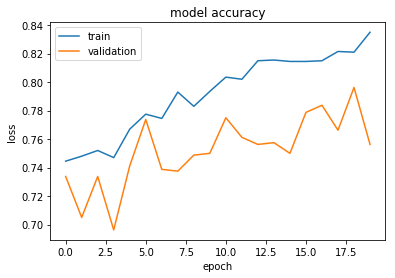

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label = 'validation')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()


## Fine-Tuning a Network

### Training the FC layers

In [70]:
import keras
from keras import applications
from keras import models
from keras.layers import Dropout, Flatten, Dense
import numpy as np

batch_size = 16

# Load the VGG16 network with the pretrained imagenet weights. Don't include the fully connected layers.

model = applications.VGG16(include_top=False, weights='imagenet') 

# Generate feature map for training data
generator = datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,  
        shuffle=False)    
        
bottleneck_features_train = model.predict_generator(generator, 2000//batch_size)

# save the output as a Numpy array
np.save('bottleneck_features_train.npy', bottleneck_features_train)

Found 2000 images belonging to 2 classes.


In [71]:
# Generate feature map for validation data
generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, 800//batch_size)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

Found 800 images belonging to 2 classes.


In [29]:
from keras.utils.np_utils import to_categorical
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  

num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
  
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  

generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
    
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 3s 1ms/step - loss: 4.3805 - acc: 0.7085 - val_loss: 3.3741 - val_acc: 0.7800
Epoch 2/50
2000/2000 [==============================] - 2s 1ms/step - loss: 3.2302 - acc: 0.7900 - val_loss: 4.0267 - val_acc: 0.7425
Epoch 3/50
2000/2000 [==============================] - 2s 1ms/step - loss: 3.0858 - acc: 0.8015 - val_loss: 3.2622 - val_acc: 0.7887
Epoch 4/50
2000/2000 [==============================] - 2s 1ms/step - loss: 2.5993 - acc: 0.8285 - val_loss: 2.5421 - val_acc: 0.8363
Epoch 5/50
2000/2000 [==============================] - 2s 1ms/step - loss: 2.3333 - acc: 0.8505 - val_loss: 2.4245 - val_acc: 0.8450
Epoch 6/50
2000/2000 [==============================] - 2s 1ms/step - loss: 2.5613 - acc: 0.8345 - val_loss: 2.9007 - val_acc: 0.8137
Epoch 7/50
2000/2000 [==============================] - 2s 1ms/ste

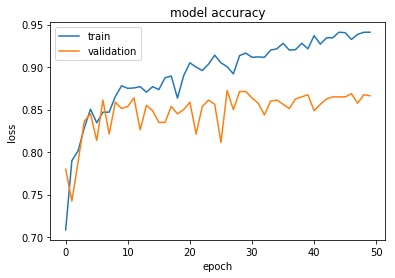

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label = 'validation')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

Confusion matrix, without normalization
[[370  30]
 [ 77 323]]


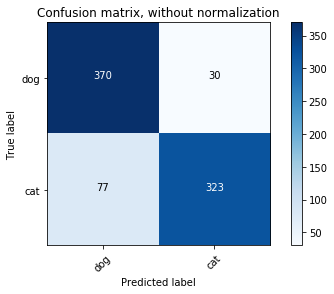

Normalized confusion matrix
[[0.925  0.075 ]
 [0.1925 0.8075]]


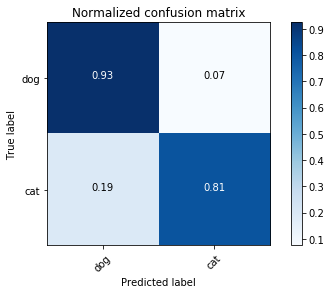

In [43]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
y_prob=model.predict(validation_data)
y_pred = np.round(y_prob[:,0])
cnf_matrix=confusion_matrix(validation_labels, y_pred)
class_names = ['dog','cat']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Fine tuning the convolution layers

In [65]:
# build model
base_model = applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

# Create a model
fullyconnected_model = Sequential()
fullyconnected_model.add(Flatten(input_shape=base_model.output_shape[1:]))
fullyconnected_model.add(Dense(256, activation='relu'))
fullyconnected_model.add(Dropout(0.5))
fullyconnected_model.add(Dense(1, activation='sigmoid'))

fullyconnected_model.load_weights('bottleneck_fc_model.h5')

model = models.Model(inputs= base_model.input, outputs= fullyconnected_model(base_model.output))

for layer in model.layers[:-3]:
    layer.trainable = False

adam=keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

print('model compiled')

model.summary()

model compiled
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [66]:
batch_size = 16

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

# fine-tune the model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/20
125/125 [==============================] - 530s 4s/step - loss: 1.3669 - acc: 0.8080 - val_loss: 0.6868 - val_acc: 0.8588
Epoch 2/20
125/125 [==============================] - 517s 4s/step - loss: 0.5102 - acc: 0.8785 - val_loss: 0.6168 - val_acc: 0.8562
Epoch 3/20
125/125 [==============================] - 529s 4s/step - loss: 0.2945 - acc: 0.9070 - val_loss: 0.3120 - val_acc: 0.8975
Epoch 4/20
125/125 [==============================] - 525s 4s/step - loss: 0.1542 - acc: 0.9425 - val_loss: 0.3250 - val_acc: 0.8900
Epoch 5/20
125/125 [==============================] - 572s 5s/step - loss: 0.1119 - acc: 0.9560 - val_loss: 0.3398 - val_acc: 0.8925
Epoch 6/20
125/125 [==============================] - 526s 4s/step - loss: 0.1018 - acc: 0.9625 - val_loss: 0.3375 - val_acc: 0.8875
Epoch 7/20
125/125 [==============================] - 3234s 26s/step - loss: 0.0855 - acc: 0.9675 - val_loss: 0.2990 - 

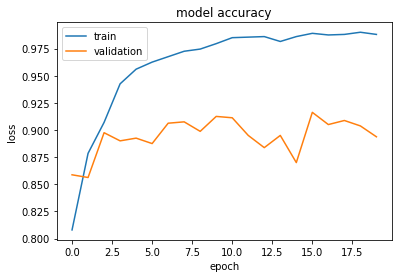

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label = 'validation')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

## References


[Keras tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

[original data](http://www.robots.ox.ac.uk/~vgg/data/pets/)

[Good Blog Post](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)